In [1]:
import pandas as pd
import numpy as np
import category_encoders as ce

import matplotlib.pyplot as plt
import seaborn as sns

import warnings # для отключения предупреждений
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None

ПОДГОТОВКА ДАННЫХ

In [61]:
train=pd.read_csv('data/hotels_train.csv')
test=pd.read_csv('data/hotels_test.csv')

In [62]:
# избавимся от дублей
train.duplicated().value_counts() # 307
train.drop_duplicates(inplace=True, ignore_index=True)

In [63]:
# для обратного разделения данных
train['sample']=1
test['sample']=0

# объединяем
test['reviewer_score']=0 
data=pd.concat([test,train])

In [64]:
data.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102,0,0.0
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443,0,0.0
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,2.161520,0,0.0


ОЧИСТКА ДАННЫХ

In [65]:
# Количество названий отелей
print('кол-во названий:', data['hotel_name'].value_counts().to_frame().shape[0])

# Возможно, некоторые отели могут иметь одинаковые названия. Проверим это через количество адресов
print('кол-во адресов:', data['hotel_address'].value_counts().to_frame().shape[0])

# Два отеля имеют одинаковое название 
# Применим порядковое кодирование для адресов
ord_encoder = ce.OrdinalEncoder()
data['hotel_id']= ord_encoder.fit_transform(data[['hotel_address']])

# Имея уникальный идентификатор отеля, удалим названия
data=data.drop(columns='hotel_name')

кол-во названий: 1492
кол-во адресов: 1493


НОВЫЕ ПРИЗНАКИ

Даты

In [66]:
# Добавим признак weekday
data['weekday']=pd.to_datetime(data['review_date']).dt.weekday

# Выделяем из признака days_since_review количество дней
data['days_since_review']=data['days_since_review'].str.split().str[0].astype(int)

# Из признака review_date выделяем отдельно год, месяц, число 
data['year_review']=data['review_date'].str.split('/').str[-1].astype(int)
data['month_review']=data['review_date'].str.split('/').str[-3].astype(int)
data['day_of_month_review']=data['review_date'].str.split('/').str[-2].astype(int)

# Удаляем признак review_date, ставший ненужным
data=data.drop(columns='review_date')

Количество отзывов

In [67]:
# Для каждого отеля добавим количество отзывов

df11=data[['hotel_id','reviewer_score']].groupby(['hotel_id'],as_index=False)['reviewer_score'].count().rename(columns={'reviewer_score':'reviewer_score_count'})
data=data.merge(df11, how ='left', on ='hotel_id')

Страны

In [68]:
# выделим страну отеля
data['hotel_address'].str.split().str[-2:].value_counts() # выделяем страну, убеждаемся, что kingdom только одно

#добавляем признак country 
data['hotel_country']=data['hotel_address'].str.split().str[-1]
data['hotel_country']=data['hotel_country'].replace('Kingdom','United Kingdom')

# признак совпадения страны посетителя и страны отеля
data['country_is_nationality']=data['hotel_country'].str.strip().str.lower()==data['reviewer_nationality'].str.strip().str.lower()
data['country_is_nationality']=data['country_is_nationality'].replace({False:0,True:1})

# кодируем страны отеля
country_dic1={'United Kingdom':1, 'Spain':2, 'France':3, 'Netherlands':4, 'Austria':5, 'Italy':6}
data['hotel_country']=data['hotel_country'].map(country_dic1)

# закодируем страны посетителей
# т.к. страны отеля закодированы по порядку, и есть признак совпадения страны отеля и посетителя, 
# попробуем применить иной способ кодирования - частота упоминания
country_dic2=data['reviewer_nationality'].value_counts(normalize=True).to_dict()
data['reviewer_nationality']=data['reviewer_nationality'].replace(country_dic2)

Теги

In [69]:
# Удалим из тегов лишние знаки
print('теги до преобразования:',data['tags'].loc[0])
data['tags']=data['tags'].str.replace('[', '').str.replace(']','').str.replace("' ",'').str.replace(" '",'')
print('теги после преобразования:',data['tags'].loc[0])

теги до преобразования: [' Leisure trip ', ' Couple ', ' Double Room ', ' Stayed 2 nights ']
теги после преобразования: Leisure trip, Couple, Double Room, Stayed 2 nights


In [70]:
# Для удобства создадим таблицу встречающихся тегов, в которой столбцами являются порядковые номера тегов в исходном data['tags']
tags_df=data['tags'].str.split(', ', expand=True)

# И еще одну таблицу всех тегов, записанных в один столбец (немного топорным методом)
tags_df_all=pd.concat([tags_df[0],tags_df[1],tags_df[2],tags_df[3],tags_df[4],tags_df[5]], ignore_index=False).to_frame()

# количество уникальных тегов
print('количество уникальных тегов:',tags_df_all.value_counts().to_frame().shape[0])

количество уникальных тегов: 2428


In [71]:
# Выделим признак night_count - количество ночей, проведенных в отеле
df_nights=tags_df_all[tags_df_all[0].str.contains('Stayed').fillna(False)] # игнорируя None, выделяем тег, содержащий 'Stayed'
df_nights['night_count']=df_nights[0].str.split().str[1].astype(int) # из выделенного тега извлекаем количество ночей
data=data.join(df_nights['night_count']) #присоединяем night_count к исходной таблице

data['night_count'].isnull().value_counts() # пропуски в новом признаке присутствуют
data['night_count'] = data['night_count'].fillna(data['night_count'].mode()[0]) # заполним пропуски модой

In [72]:
# Выделим признаки, характеризующие тип поездки (Business или Leisure) по аналогии с признаком night_count

df_trip=tags_df_all[tags_df_all[0].str.contains('trip').fillna(False)]
df_trip=pd.get_dummies(data=df_trip, prefix='is')
data=data.join(df_trip) #присоединяем новые признаки к исходной таблице

data['is_Business trip'].isnull().value_counts() 
data['is_Leisure trip'].isnull().value_counts() # пропуски в новых признаках присутствуют

data[['is_Business trip','is_Leisure trip']] = data[['is_Business trip','is_Leisure trip']].fillna(0) # здесь заполним пропуски нулям

In [73]:
# выделим остальные достаточно популярные группы тегов в отдельные признаки
data['is_Couple']=data['tags'].str.contains('Couple').apply(lambda x: 1 if x == True else 0)
data['is_Group']=data['tags'].str.contains('Group').apply(lambda x: 1 if x == True else 0)
data['is_Solo_traveler']=data['tags'].str.contains('Solo traveler').apply(lambda x: 1 if x == True else 0)
data['is_Family_young_ch']=data['tags'].str.contains('Family with young children').apply(lambda x: 1 if x == True else 0)
data['is_Family_old_ch']=data['tags'].str.contains('Family with older children').apply(lambda x: 1 if x == True else 0)
data['Sub_from_mob']=data['tags'].str.contains('Submitted from a mobile device').apply(lambda x: 1 if x == True else 0)

In [74]:
# здесь я сперва заменил теги частотой их упоминания, но это ничего толком не дало
# решил не оставлять

data=data.drop(columns=['tags'])

Отзывы

In [75]:
# теперь ясно, что следовало использовать специальные инструменты NLP
# ниже представлены результаты "мучений"

очистка отзывов

In [76]:
# заметим, что количеству слов в отзыве не соответсвует признак 'review_total_xxxxxx_word_counts'
# исправим 

data['review_total_positive_word_counts_TRUE']=data['positive_review'].str.strip().str.split(' ').str.len()
data['review_total_negative_word_counts_TRUE']=data['negative_review'].str.strip().str.split(' ').str.len()
data[['review_total_positive_word_counts_TRUE','review_total_positive_word_counts','positive_review',
      'review_total_negative_word_counts_TRUE','review_total_negative_word_counts','negative_review']].head(3)

,review_total_positive_word_counts_TRUE,review_total_positive_word_counts,positive_review,review_total_negative_word_counts_TRUE,review_total_negative_word_counts,negative_review
0,60,62,Hotel was great clean friendly staff free bre...,50,52,Would have appreciated a shop in the hotel th...
1,2,0,No Positive,9,10,No tissue paper box was present at the room
2,4,5,Nice welcoming and service,1,3,Pillows


In [77]:
data=data.drop(columns=['review_total_positive_word_counts','review_total_negative_word_counts'])

In [78]:
# Отзывы могут содержать в некотором смысле противоречивую информацию
# Например, negative_review содержит такие словосочетания как: No Negative, Everything was perfect и т.д.

# список "позитива" в негативном отзыве 
pos_in_neg_list=['nothing','no negative','nothing','n a',
        'none','na','everything was great',
        'all good','Everything was perfect',
        'nothing to dislike','nothing to complain about','no','no complaints',
        'nothing really','nothing at all','everything was good','nothing all good',
        'nothing not to like','liked everything','nothing comes to mind',
        'there was nothing i didn t like','all was good','everything was fine','non',
        'nothing it was perfect','nothing everything was perfect',
        'absolutely nothing','no negatives','it was all good','','nil','',
        'everything was perfect','i liked everything']

# список индексов столбца negative_review, которые содержат "позитив"
corr_list1=data.index[data['negative_review'].str.strip().str.lower().isin(pos_in_neg_list)==True].to_list()
len(corr_list1) # 119437

# заменяем позитивные слова в негативном отзыве на NaN
data['negative_review'].loc[corr_list1]=data['negative_review'].loc[corr_list1].apply(lambda x : np.NaN )

# и количество слов в review_total_negative_word_counts_TRUE на ноль, ведь так оно и есть
data['review_total_negative_word_counts_TRUE'].loc[corr_list1]=data['review_total_negative_word_counts_TRUE'].loc[corr_list1].apply(lambda x : 0 )

In [79]:
# Выполняем ту же операцию с позитивным отзывом

# список "негатива" в позитивном отзыве 
neg_in_pos_list=['nothing','no positive','nothing','n a',
        'none','na','nothing really','nothing at all','nothing comes to mind',
        'non','absolutely nothing','no positive','','nil','']

# индексы
corr_list2=data.index[data['positive_review'].str.strip().str.lower().isin(neg_in_pos_list)==True].to_list()
len(corr_list2) # 28486

# заменяем позитивные слова на NaN
data['positive_review'].loc[corr_list2]=data['positive_review'].loc[corr_list2].apply(lambda x : np.NaN )

# и количество слов в review_total_positive_word_counts_TRUE на ноль
data['review_total_positive_word_counts_TRUE'].loc[corr_list2]=data['review_total_positive_word_counts_TRUE'].loc[corr_list2].apply(lambda x : 0 )

In [80]:
data['count_words_diff']=data['review_total_positive_word_counts_TRUE']-data['review_total_negative_word_counts_TRUE']

извлекаем из отзывов конкретику

In [81]:
good_review_list=['location','everything','breakfast','staff','every thing','room','bed','price','leaving']

good_location=data.index[data['positive_review'].str.strip().str.lower().str.contains('location',na=False,regex=False)].to_list()
good_staff=data.index[data['positive_review'].str.strip().str.lower().str.contains('staff',na=False,regex=False)].to_list()
good_room=data.index[data['positive_review'].str.strip().str.lower().str.contains('room',na=False,regex=False)].to_list()
good_bed=data.index[data['positive_review'].str.strip().str.lower().str.contains('bed',na=False,regex=False)].to_list()
good_breakfast=data.index[data['positive_review'].str.strip().str.lower().str.contains('breakfast',na=False,regex=False)].to_list()
good_price=data.index[data['positive_review'].str.strip().str.lower().str.contains('price',na=False,regex=False)].to_list()
good_leaving=data.index[data['positive_review'].str.strip().str.lower().str.contains('leaving',na=False,regex=False)].to_list()
good_everything=data.index[data['positive_review'].str.strip().str.lower().str.contains('everything',na=False,regex=False)].to_list()

data['pos_location']=0
data['pos_location'].to_frame().loc[good_location]=1
data['pos_staff']=0
data['pos_staff'].to_frame().loc[good_staff]=1
data['pos_room']=0
data['pos_room'].to_frame().loc[good_room]=1
data['pos_bed']=0
data['pos_bed'].to_frame().loc[good_bed]=1
data['pos_breakfast']=0
data['pos_breakfast'].to_frame().loc[good_breakfast]=1
data['pos_price']=0
data['pos_price'].to_frame().loc[good_price]=1
data['pos_leaving']=0
data['pos_leaving'].to_frame().loc[good_leaving]=1
data['pos_everything']=0
data['pos_everything'].to_frame().loc[good_everything]=1

In [82]:
bad_review_list=['location','everything','breakfast','staff','every thing','room','bed','price','leaving']

bad_location=data.index[data['negative_review'].str.strip().str.lower().str.contains('location',na=False,regex=False)].to_list()
bad_staff=data.index[data['negative_review'].str.strip().str.lower().str.contains('staff',na=False,regex=False)].to_list()
bad_room=data.index[data['negative_review'].str.strip().str.lower().str.contains('room',na=False,regex=False)].to_list()
bad_bed=data.index[data['negative_review'].str.strip().str.lower().str.contains('bed',na=False,regex=False)].to_list()
bad_breakfast=data.index[data['negative_review'].str.strip().str.lower().str.contains('breakfast',na=False,regex=False)].to_list()
bad_price=data.index[data['negative_review'].str.strip().str.lower().str.contains('price',na=False,regex=False)].to_list()
bad_leaving=data.index[data['negative_review'].str.strip().str.lower().str.contains('leaving',na=False,regex=False)].to_list()

data['neg_location']=0
data['neg_location'].to_frame().loc[bad_location]=1
data['neg_staff']=0
data['neg_staff'].to_frame().loc[bad_staff]=1
data['neg_room']=0
data['neg_room'].to_frame().loc[bad_room]=1
data['neg_bed']=0
data['neg_bed'].to_frame().loc[bad_bed]=1
data['neg_breakfast']=0
data['neg_breakfast'].to_frame().loc[bad_breakfast]=1
data['neg_price']=0
data['neg_price'].to_frame().loc[bad_price]=1
data['neg_leaving']=0
data['neg_leaving'].to_frame().loc[bad_leaving]=1

извлекаем эмоциональную окраску

In [83]:
data['pos_excellent']=data['positive_review'].str.lower().str.contains('excellent').apply(lambda x: 1 if x == True else 0)
data['pos_great']=data['positive_review'].str.lower().str.contains('great').apply(lambda x: 1 if x == True else 0)
data['pos_wonderful']=data['positive_review'].str.lower().str.contains('wonderful').apply(lambda x: 1 if x == True else 0)
data['pos_amazing']=data['positive_review'].str.lower().str.contains('amazing').apply(lambda x: 1 if x == True else 0)

data['good_sum']=data['pos_amazing']+data['pos_excellent']+data['pos_wonderful']+data['pos_great']

data['neg_awful']=data['negative_review'].str.lower().str.contains('awful').apply(lambda x: 1 if x == True else 0)
data['neg_terrible']=data['negative_review'].str.lower().str.contains('terrible').apply(lambda x: 1 if x == True else 0)
data['neg_bad']=data['negative_review'].str.lower().str.contains('bad').apply(lambda x: 1 if x == True else 0)
data['neg_horrible']=data['negative_review'].str.lower().str.contains('horrible').apply(lambda x: 1 if x == True else 0)

data['bad_sum']=data['neg_awful']+data['neg_terrible']+data['neg_bad']+data['neg_horrible']

In [84]:
# введем условный показатель эмоциональной окраски
data['ratio_sum_emotion']=data['good_sum']/(data['bad_sum']+data['good_sum'])
data['ratio_sum_emotion']=data['ratio_sum_emotion'].fillna(0) # "нет времени объяснять, просто заполни пропуски нулями"


# ограничиваясь выполненными преобразованиями, удалим отзывы
data=data.drop(columns=['positive_review','negative_review'])

ПРЕОБРАЗОВАНИЕ И ОТБОР ПРИЗНАКОВ

In [85]:
# определение местоположения ничего существенного мне не смогло добавить
data=data.drop(columns=['lat','lng','hotel_address'])


In [86]:
# непрерывные признаки
num_cols =['additional_number_of_scoring','total_number_of_reviews','total_number_of_reviews_reviewer_has_given','days_since_review',
           'reviewer_score_count','night_count','review_total_positive_word_counts_TRUE','review_total_negative_word_counts_TRUE',
           'count_words_diff']

# категориальные признаки
cat_cols = ['average_score','reviewer_nationality','hotel_id','weekday','year_review','month_review','day_of_month_review','hotel_country',
            'bad_sum','ratio_sum_emotion']

# бинарные признаки
bi_cols=['country_is_nationality','is_Business trip', 'is_Leisure trip', 'is_Couple','is_Group','is_Solo_traveler','is_Family_young_ch',
            'is_Family_old_ch','Sub_from_mob','pos_location','pos_staff','pos_room','pos_bed','pos_breakfast','pos_price','pos_leaving',
            'pos_everything', 'neg_location','neg_staff','neg_room','neg_bed','neg_breakfast','neg_price','neg_leaving','pos_excellent',
            'pos_great', 'pos_wonderful','pos_amazing','good_sum','neg_awful','neg_terrible','neg_bad','neg_horrible',]

# строго говоря (наверное), признак ratio_sum_emotion не является таким категориальным, как его соседи по списку, т.к он образован из бинарных признаков

In [87]:
# простые преобразования через mm_scaler и r_scaler ничего не дали, вероятно, нужны другие приемы
# удаление малозначимых признаков ухудшает качество модели

<AxesSubplot:>

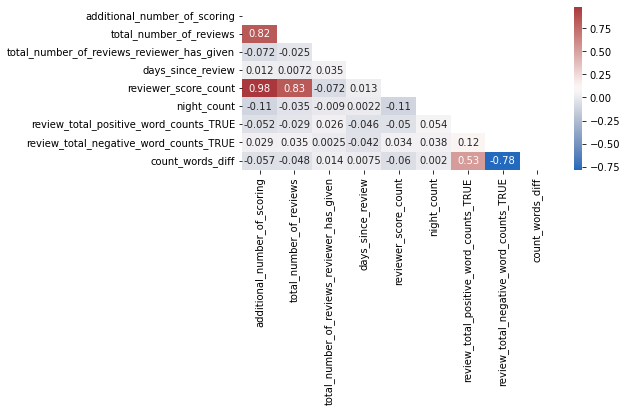

In [88]:
plt.figure(figsize=(7, 3))
sns.heatmap(data[num_cols].corr(), annot=True, cmap='vlag', mask=np.triu(data[num_cols].corr()))

In [89]:
data=data.drop(columns=['reviewer_score_count','total_number_of_reviews'])

<AxesSubplot:>

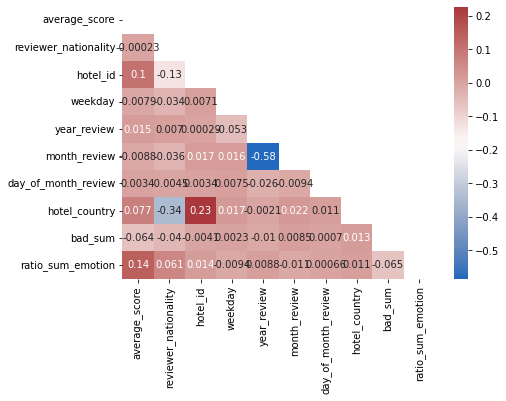

In [90]:
plt.figure(figsize=(7, 5))
sns.heatmap(data[cat_cols].corr(method='spearman'), cmap='vlag',annot=True, mask=np.triu(data[cat_cols].corr()))

In [91]:
# для бинарных признаков воспользуемся корреляцией Мэтьюса (где-то прочитал, что для бинарных Метьюс - самое то)
from sklearn.metrics import matthews_corrcoef
len(bi_cols) # 33

# т.к. нет специальной функции (не нашел), будем выдумывать что-то свое

# список кортежей всех возможных пар бинарных признаков
res=[]
n=len(bi_cols)
for i in range(n):
    for j in range(i+1,n):
        res.append((bi_cols[i],bi_cols[j]))     
len(res) # 528

# словарь с парой признаков и коэффициентом корреляции
dic_res={}
for i in range(len(res)):
    dic_res.update({res[i]:matthews_corrcoef(data[res[i][0]],data[res[i][1]])})
    
# для удобства создадим таблицу
df_bicorr=pd.DataFrame({'couple':dic_res.keys(),'m_corr':dic_res.values()})
# используя sort_values, можно убедиться, что пара с сильной корреляцией - (is_Business trip, is_Leisure trip)


In [92]:
data=data.drop(columns=['is_Leisure trip'])

ОБУЧЕНИЕ МОДЕЛИ

In [106]:
# Производим обратную замену

train=data.query('sample==1')
test=data.query('sample==0')

X=train.drop(columns=['reviewer_score'])
y=train['reviewer_score']

In [104]:
# Загружаем специальный инструмент для разбивки:  
from sklearn.model_selection import train_test_split  

In [108]:
# выделим 20% данных на валидацию
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [109]:
# Импортируем необходимые библиотеки:  
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  
  
# Создаём модель  
regr = RandomForestRegressor(n_estimators=100)  
      
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)  


In [110]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.12607493329559213


In [121]:
submission=pd.read_csv('data/submission.csv')

In [122]:
predict_submission = pd.Series(regr.predict(test.drop(['reviewer_score'], axis=1)))
submission['reviewer_score']=predict_submission
submission.to_csv('submission_fin.csv', index=False)

In [124]:
!pip freeze > requirements.txt